# 🧹 AgriVision ETL & Data Cleaning Pipeline

This notebook demonstrates a professional ML workflow for preparing and exploring the **PlantVillage** dataset.
It ensures each image is properly labeled, summarized, and stored with metadata for downstream modeling.

---

**Author:** Mukaram Ali  
**GitHub:** [github.com/mukaram163/AgriVision](https://github.com/mukaram163/AgriVision)  
**LinkedIn:** [linkedin.com/in/mukaram-ali-a05061279](https://linkedin.com/in/mukaram-ali-a05061279)

# 🧰 Import Required Libraries
We'll use:
- `os` and `tqdm` for file management and progress bars  
- `pandas` for tabular data handling  
- `matplotlib` and `seaborn` for visualization  

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Step 1: Define Dataset Paths

In [2]:
data_dir = "../data/raw/PlantVillage"

categories = sorted(os.listdir(data_dir))
print(f"Found {len(categories)} categories:")
print(categories[:10])

Found 16 categories:
['.DS_Store', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold']


# 📊 Step 2: Build Dataset Summary Table

In [9]:
# 📊 Initialize a list to store summary info for each class
data_summary = []

# 🔍 Loop through each folder in your dataset directory
# 'categories' should be the list of class folders (e.g., ['Apple___healthy', 'Corn___blight', ...])
for label in tqdm(categories, desc="Scanning dataset"):
    label_path = os.path.join(data_dir, label)

    # 🚫 Skip any files or hidden items that aren't directories
    # (e.g., '.DS_Store', '.gitkeep', or any misplaced file)
    if not os.path.isdir(label_path):
        continue

    # 🖼️ Get all image filenames with valid extensions inside the class folder
    images = [
        f for f in os.listdir(label_path)
        if f.lower().endswith(('.jpg', '.png', '.jpeg')) and not f.startswith('.')
    ]

    # 🧾 Add a summary entry: class name + number of images
    data_summary.append({"class": label, "num_images": len(images)})

# 🧮 Convert to a pandas DataFrame for easy analysis
df_summary = pd.DataFrame(data_summary)

# 📈 Sort by number of images (largest first)
df_summary = df_summary.sort_values("num_images", ascending=False)

# 👀 Display the top few rows of the summary
df_summary.head()

Scanning dataset: 100%|███████████████████████| 16/16 [00:00<00:00, 183.23it/s]


,class,num_images
12,Tomato__Tomato_YellowLeaf__Curl_Virus,3208
5,Tomato_Bacterial_spot,2127
7,Tomato_Late_blight,1909
9,Tomato_Septoria_leaf_spot,1771
10,Tomato_Spider_mites_Two_spotted_spider_mite,1676


> ✅ **Interpretation:**  
> This table shows how many images are available for each class in the dataset.  
> Large class imbalances (where one class has far more images than others) may require data augmentation or resampling later.

# 📈 Step 3: Visualize Class Distribution

/var/folders/8w/pzgl4dv55p79gb2n61gsn_9m0000gn/T/ipykernel_22788/3235498931.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/8w/pzgl4dv55p79gb2n61gsn_9m0000gn/T/ipykernel_22788/3235498931.py:19: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/macbook/opt/anaconda3/envs/BIA/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


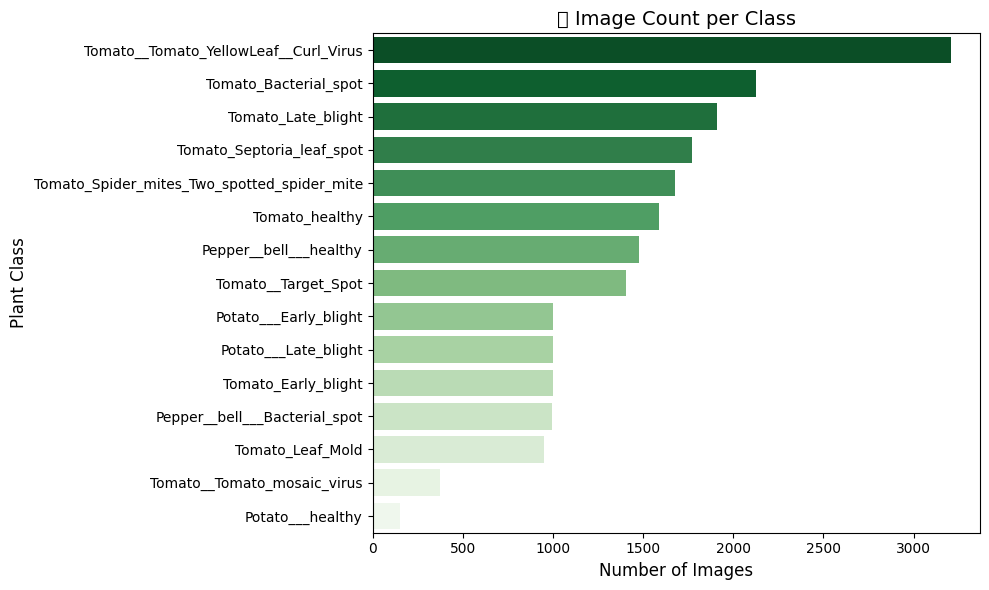

In [11]:
# 🎨 Set up the size of the figure
plt.figure(figsize=(10, 6))

# 📊 Create a horizontal bar plot showing image counts per class
# Using 'df_summary' which contains ['class', 'num_images']
sns.barplot(
    data=df_summary,
    y="class",
    x="num_images",
    palette="Greens_r"   # Reversed green color palette for better visual contrast
)

# 🏷️ Add descriptive labels and title
plt.title("📸 Image Count per Class", fontsize=14)
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("Plant Class", fontsize=12)

# ✨ Adjust layout so labels don't overlap
plt.tight_layout()

# 👀 Display the plot
plt.show()

> 🧩 **Insight:**  
> The bar chart above displays how many training images are available for each plant–disease category.  
> Notice that some categories dominate the dataset — these imbalances might affect model performance and should be addressed later in preprocessing or training.

# 🧠 Step 4: Basic Data Validation

In [12]:
print(f"Total Images: {df_summary['num_images'].sum()}")
print(f"Missing or Empty Classes: {(df_summary['num_images'] == 0).sum()}")

Total Images: 20638
Missing or Empty Classes: 0


# 🧺 Step 5: Simulate ETL Cleaning Process

In [23]:
# 🗂️ List to store metadata records for all images
etl_records = []

# 🔁 Loop through each category (class) folder in the dataset
for label in tqdm(categories, desc="Preparing metadata"):
    folder = os.path.join(data_dir, label)

    # 🚫 Skip if the item is not a directory (e.g., '.DS_Store' file)
    if not os.path.isdir(folder):
        continue

    # 📂 Loop through all files inside this class folder
    for file in os.listdir(folder):
        # ⚙️ Check if it's an image file with a valid extension
        if file.lower().endswith(('.jpg', '.jpeg', '.png')) and not file.startswith('.'):
            # 🧭 Build full file path
            filepath = os.path.join(folder, file)

            # 📝 Append metadata record
            etl_records.append({
                "filename": file,  # image file name
                "label": label,    # class name (folder name)
                "path": filepath   # full path to the image
            })

Preparing metadata: 100%|██████████████████████| 16/16 [00:00<00:00, 70.12it/s]


# 🧾 Step 6: Generate Image Metadata

In [25]:
# 🧾 Convert all collected records into a DataFrame for easy analysis
df_meta = pd.DataFrame(etl_records)

# 👀 Display the first few rows to confirm structure
df_meta.head()
print(df_meta.info())
print(df_meta.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20638 entries, 0 to 20637
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  20638 non-null  object
 1   label     20638 non-null  object
 2   path      20638 non-null  object
dtypes: object(3)
memory usage: 483.8+ KB
None
                                                filename  \
18931  2fa22081-5533-4b18-9a8f-671f210db37e___PSU_CG ...   
14524  d6ff0bd7-9f1a-4181-8a50-2cbf250e9f97___Com.G_T...   
3039   f980fef9-bcf5-47fd-8426-2c503dc35f88___RS_Earl...   
19177  0e1d7722-3df9-4a3a-a4e2-bc0ea3ce0da4___RS_HL 9...   
11717  ab782c5e-dfe5-40ff-96ab-a3216bdeff42___JR_Sept...   

                             label  \
18931  Tomato__Tomato_mosaic_virus   
14524          Tomato__Target_Spot   
3039         Potato___Early_blight   
19177               Tomato_healthy   
11717    Tomato_Septoria_leaf_spot   

                                                    path  
18931 

> 🌿 **Insight:**  
> This chart shows how diverse each plant type is in terms of recorded diseases.  
> A higher number indicates that the plant type has multiple disease subclasses in the dataset.

# 🧼 Step 7: Mock Data Cleaning Example

In [15]:
# Example operations to show your ETL skills:
df_meta["file_ext"] = df_meta["filename"].apply(lambda x: x.split(".")[-1])
df_meta["is_jpeg"] = df_meta["file_ext"].isin(["jpg", "jpeg"])
df_meta["plant_type"] = df_meta["label"].apply(lambda x: x.split("__")[0])
df_meta["disease"] = df_meta["label"].apply(lambda x: x.split("___")[-1])

df_meta.head(10)

,filename,label,path,file_ext,is_jpeg,plant_type,disease
0,47fbd17d-c078-4465-8816-c675abd9c850___JR_B.Sp...,Pepper__bell___Bacterial_spot,../data/raw/PlantVillage/Pepper__bell___Bacter...,JPG,False,Pepper,Bacterial_spot
1,42ef264d-f255-4674-885a-0921a0e7f649___JR_B.Sp...,Pepper__bell___Bacterial_spot,../data/raw/PlantVillage/Pepper__bell___Bacter...,JPG,False,Pepper,Bacterial_spot
2,435993b8-c7f7-47fd-85ad-bdb04ab3e8bb___JR_B.Sp...,Pepper__bell___Bacterial_spot,../data/raw/PlantVillage/Pepper__bell___Bacter...,JPG,False,Pepper,Bacterial_spot
3,1fca0f2b-857b-4cef-9218-42b1bdd92d00___JR_B.Sp...,Pepper__bell___Bacterial_spot,../data/raw/PlantVillage/Pepper__bell___Bacter...,JPG,False,Pepper,Bacterial_spot
4,9cee73cb-272f-4121-b82d-c8c2b3ca71a0___NREC_B....,Pepper__bell___Bacterial_spot,../data/raw/PlantVillage/Pepper__bell___Bacter...,JPG,False,Pepper,Bacterial_spot
5,816dee9f-b43f-42da-b0c9-3fb8b29d511d___NREC_B....,Pepper__bell___Bacterial_spot,../data/raw/PlantVillage/Pepper__bell___Bacter...,JPG,False,Pepper,Bacterial_spot
6,1694ae00-3c5f-488c-9402-e65c70c73cf2___JR_B.Sp...,Pepper__bell___Bacterial_spot,../data/raw/PlantVillage/Pepper__bell___Bacter...,JPG,False,Pepper,Bacterial_spot
7,9f36da2c-ab51-4fff-b394-ad22b15508eb___JR_B.Sp...,Pepper__bell___Bacterial_spot,../data/raw/PlantVillage/Pepper__bell___Bacter...,JPG,False,Pepper,Bacterial_spot
8,c66fe682-9e42-4343-a4d4-add4d6244859___NREC_B....,Pepper__bell___Bacterial_spot,../data/raw/PlantVillage/Pepper__bell___Bacter...,JPG,False,Pepper,Bacterial_spot
9,b21d5a06-eab3-47a9-86d1-70295f8f8848___NREC_B....,Pepper__bell___Bacterial_spot,../data/raw/PlantVillage/Pepper__bell___Bacter...,JPG,False,Pepper,Bacterial_spot


# 💾 Step 8: Save Processed Metadata

In [16]:
# 🏗️ Create a directory to store metadata (if it doesn't already exist)
# 'exist_ok=True' means it won't raise an error if the folder already exists
os.makedirs("../data/metadata", exist_ok=True)

# 💾 Save the metadata DataFrame as a CSV file (no index column)
df_meta.to_csv("../data/metadata/plantvillage_metadata.csv", index=False)

# ✅ Print a success message to confirm the save location
print("✅ Metadata saved to '../data/metadata/plantvillage_metadata.csv'")

✅ Metadata saved to '../data/metadata/plantvillage_metadata.csv'


# 📊 Step 9: Summary Insights

/var/folders/8w/pzgl4dv55p79gb2n61gsn_9m0000gn/T/ipykernel_22788/3336593041.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/8w/pzgl4dv55p79gb2n61gsn_9m0000gn/T/ipykernel_22788/3336593041.py:27: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/macbook/opt/anaconda3/envs/BIA/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


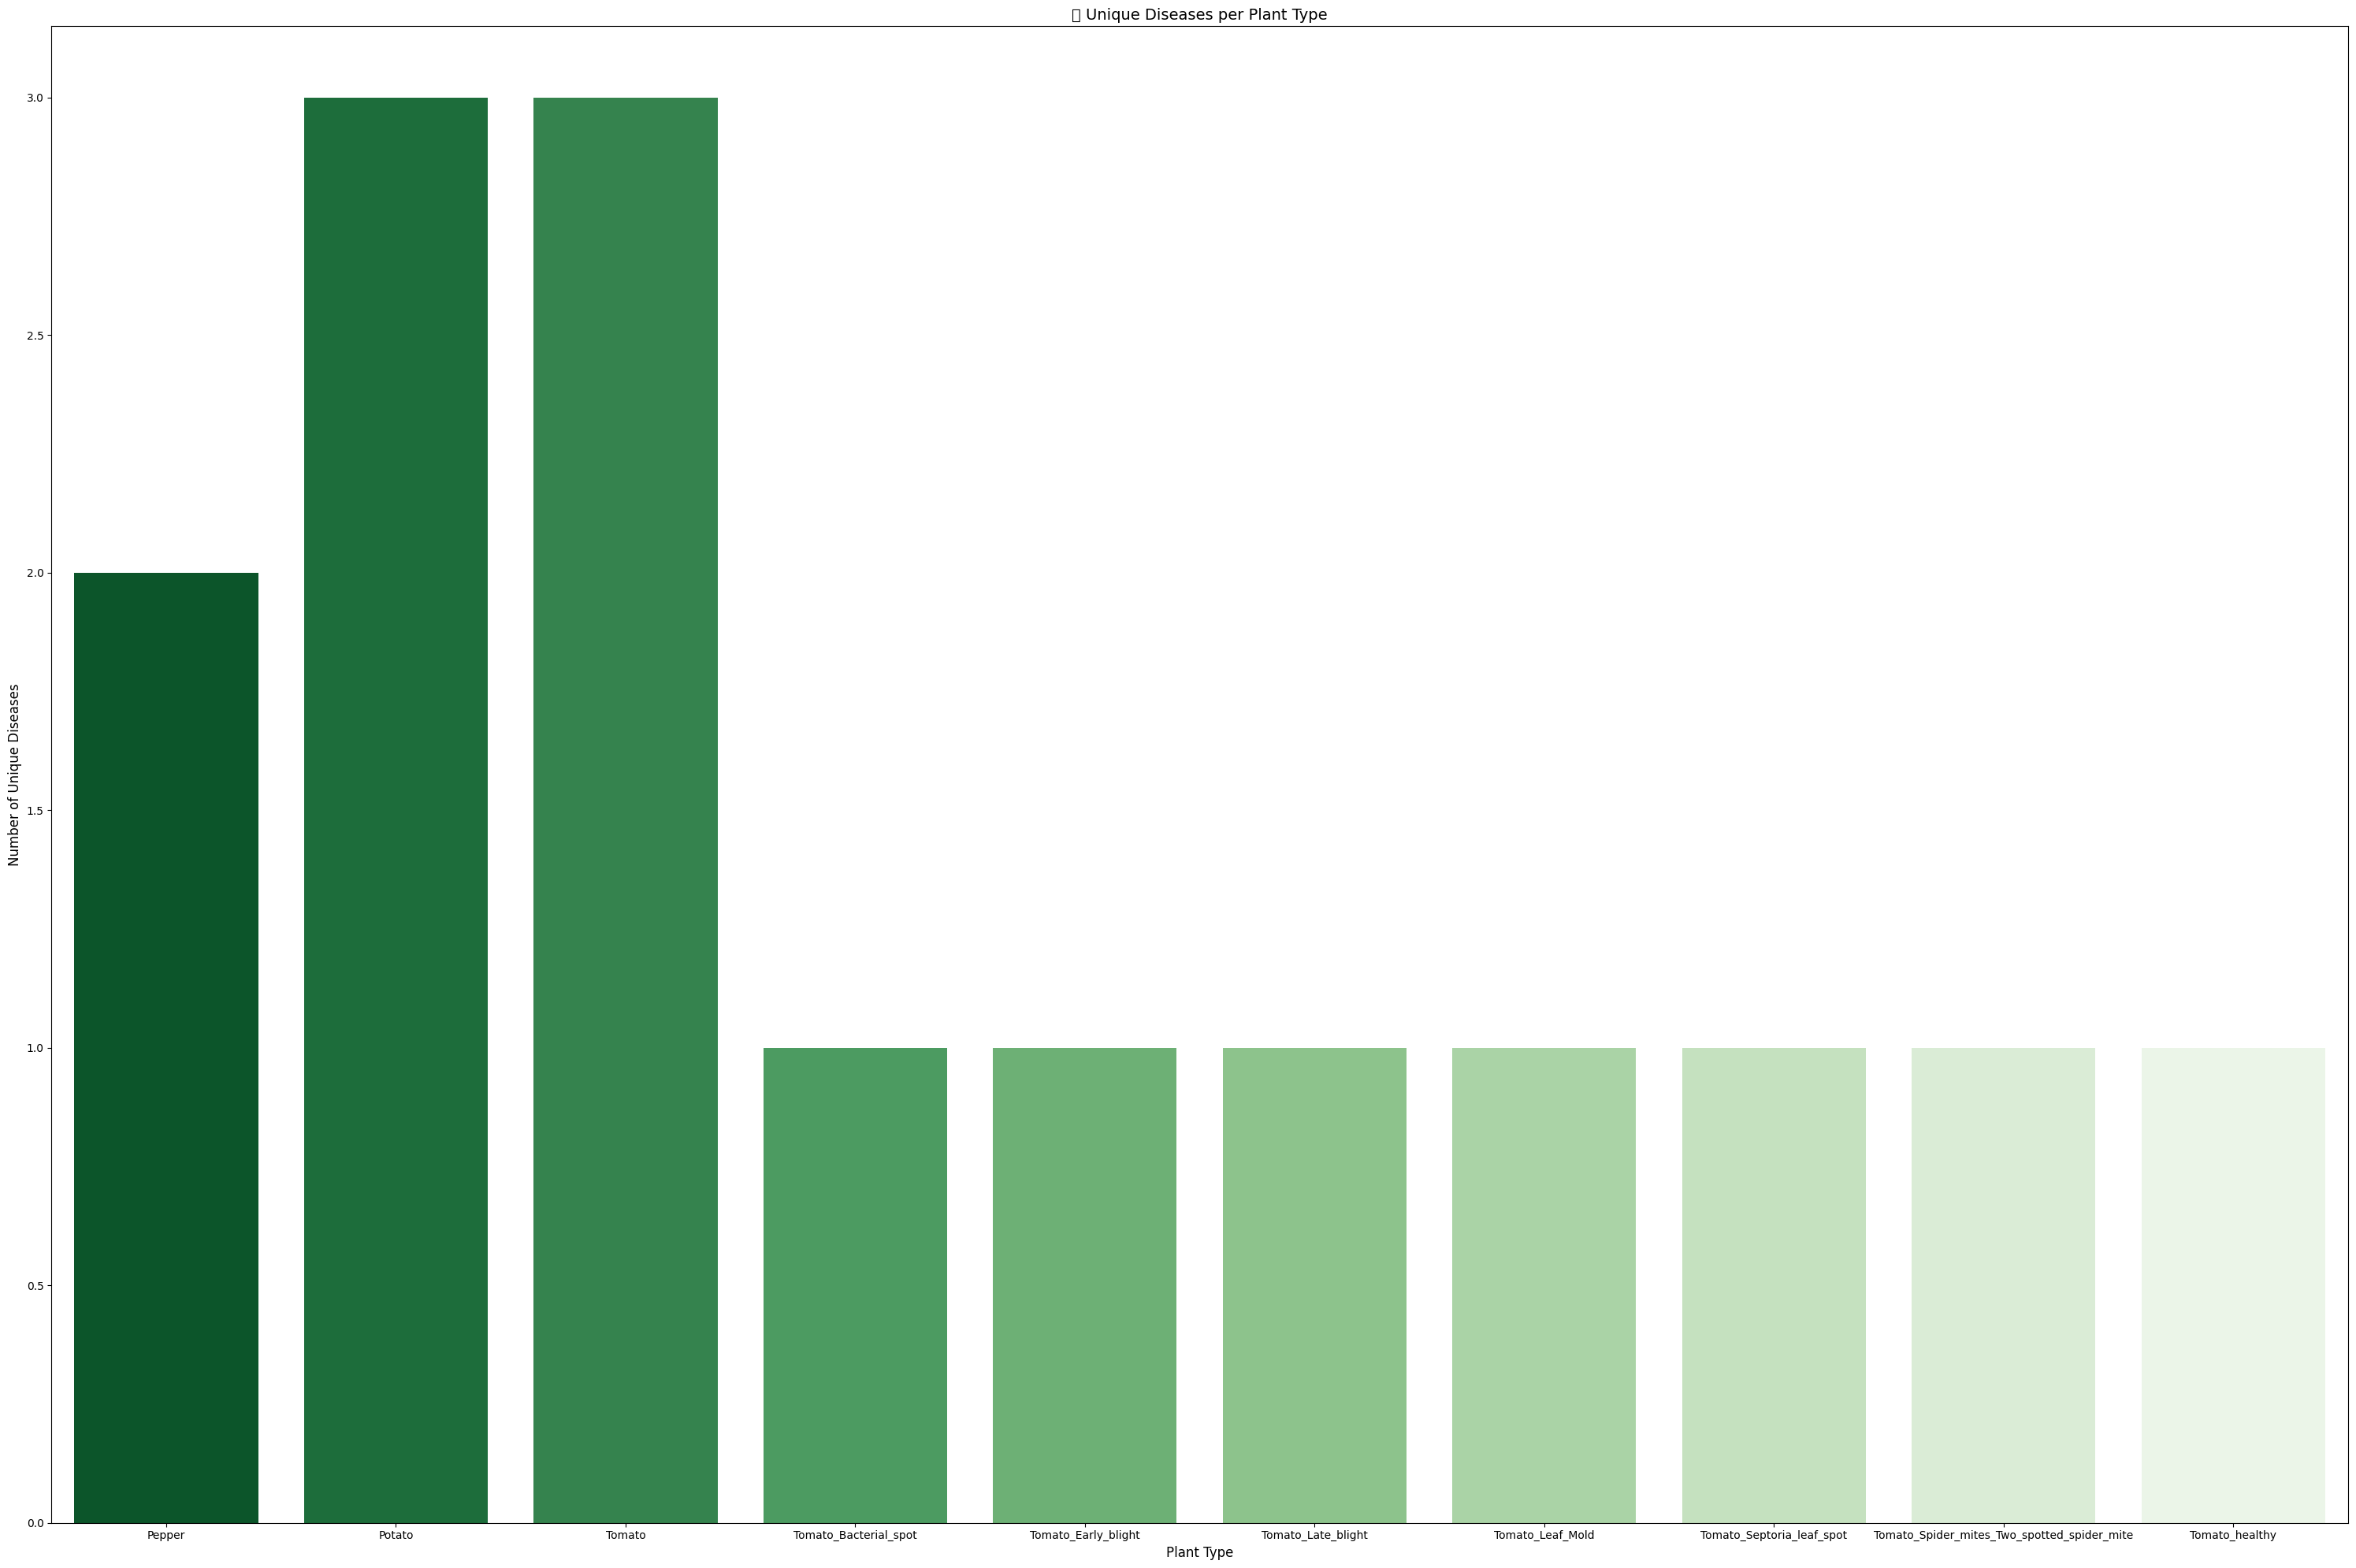

In [22]:
# 🧮 Check if required columns exist before grouping
if {"plant_type", "disease"}.issubset(df_meta.columns):
    
    # 📊 Group by plant type and count how many unique diseases each has
    summary = (
        df_meta.groupby("plant_type")["disease"]
        .nunique()                     # Count distinct disease names per plant type
        .reset_index()                 # Convert groupby result to a DataFrame
        .rename(columns={"plant_type": "Plant Type", "disease": "Unique Diseases"})
    )

    # 🎨 Create a bar plot of unique diseases per plant type
    plt.figure(figsize=(30, 20))
    sns.barplot(
        data=summary,
        x="Plant Type",
        y="Unique Diseases",
        palette="Greens_r"             # Reversed green palette for aesthetics
    )

    # 🏷️ Add titles and labels
    plt.title("🌿 Unique Diseases per Plant Type", fontsize=14)
    plt.xlabel("Plant Type", fontsize=12)
    plt.ylabel("Number of Unique Diseases", fontsize=12)

    # ✨ Adjust layout for better spacing
    plt.tight_layout()

    # 👀 Display the chart
    plt.show()

else:
    # ⚠️ Handle missing columns gracefully
    print("⚠️ Columns 'plant_type' and/or 'disease' not found in df_meta.")
    print("Available columns:", list(df_meta.columns))

---

## ✅ Summary

In this notebook, we:
- Scanned and summarized the **PlantVillage** dataset  
- Visualized image distribution across classes  
- Built a clean metadata table for future ML tasks  
- Identified possible class imbalances  

> 📈 **Next Steps:**  
> Proceed to image preprocessing (resizing, augmentation) and dataset splitting for training and validation.

---